In [105]:
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import HTML, Image

In [106]:
import logging
import time
import numpy as np

import cflib.crtp
from cflib.crazyflie import Crazyflie
from cflib.crazyflie.syncCrazyflie import SyncCrazyflie
from cflib.crazyflie.log import LogConfig
from cflib.crazyflie.syncLogger import SyncLogger

URI = f'radio://0/80/2M/E7E7E7E702'

# Only output errors from the logging framework
logging.basicConfig(level=logging.ERROR)

log_keys = ['mpcTime', 'x']

other_log_keys = []

if __name__ == '__main__':
    cflib.crtp.init_drivers(enable_debug_driver=False)

    with SyncCrazyflie(URI, cf=Crazyflie(rw_cache='./cache')) as scf:
        cf = scf.cf

        lg_stab = LogConfig(name='MPC', period_in_ms=10)
        lg_data = {}

        for key in log_keys:
            lg_stab.add_variable('ctrlMPC.' + key, 'float')
            lg_data[key] = []

        for key in other_log_keys:
            lg_stab.add_variable( key, 'float')
            lg_data[key.split('.')[1]] = []

        cf.param.set_value('kalman.resetEstimation', '1')  # will reset all states
        time.sleep(0.1)
        cf.param.set_value('kalman.resetEstimation', '0')
        time.sleep(2)
        print('Reset Kalman filter.')
                 
        cf.param.set_value('stabilizer.controller', '5')
        time.sleep(0.1)
        delta_max = 2.1
        with SyncLogger(scf, lg_stab) as logger:
            t_start = time.time()
            entry_count = 0

            for log_entry in logger:
                delta_t = time.time() - t_start

                if (delta_t < 0.3):
                    cf.commander.send_position_setpoint(0, 0.5, 0.5, 0)
                else:
                    cf.commander.send_position_setpoint(0, 0, 0.5, 0)
                for key, value in log_entry[1].items():
                    lg_data[key.split('.')[1]].append(value)

                entry_count += 1

                if delta_t > delta_max:  # x100 data points
                    break

        print('Saving data...')
        for key in lg_data.keys():
            lg_data[key] = np.array(lg_data[key])

        np.savez('quad_data/quad_traj', **lg_data)

        for i in range(10):
            cf.commander.send_stop_setpoint()
            time.sleep(0.1)

print('Done!') 

Reset Kalman filter.
Saving data...
Done!


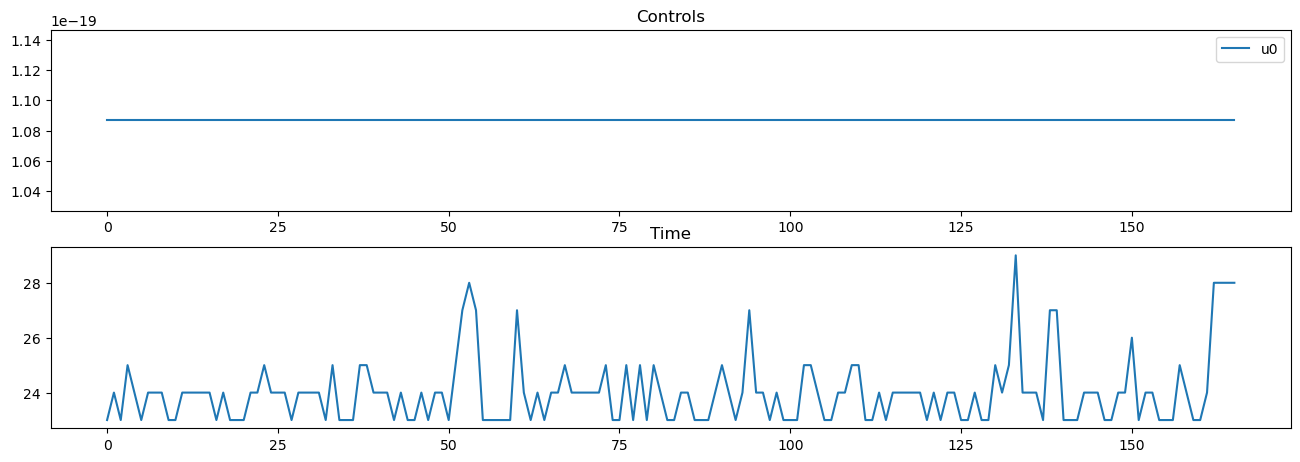

In [108]:
import os
N = int(delta_max * 100) - 1
if os.path.isfile('quad_data/quad_traj.npz'):
    npzfile = np.load('quad_data/quad_traj.npz')

    plt.rcParams["figure.figsize"] = (16,8)
    fig = plt.figure()

    ax = fig.add_subplot(311, title='Controls')
    ax.plot(npzfile['x'][10:N], label='u0')
    ax.legend()

    ax = fig.add_subplot(312, title='Time')
    ax.plot(npzfile['mpcTime'][10:N], label='Time')  
      
else:
    print('No flight data found.')